In [6]:
#packages
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from scipy.linalg import lstsq

In [7]:
def fast_sketch_matrix(m, n_columns):
    row_indices = np.random.randint(0, m, size=n_columns)  # Pick one random row per column
    col_indices = np.arange(n_columns)  # Each column gets one entry
    values = np.random.choice([1, -1], size=n_columns)  # ±1 values

    # Directly construct the sparse matrix
    S = csr_matrix((values, (row_indices, col_indices)), shape=(m, n_columns))

    return S

In [8]:
def gaussian_sketch_matrix(m, n):
    sketch_matrix = np.random.randn(m, n)
    return sketch_matrix

In [9]:
def sketch_matrix(m, n_columns, non_zero_entries):
    #matrix with all zero entries
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    
    #loop through each columns to edit the non zero entries in
    for col in range(n_columns):
        # Randomly select position of non_zero entries
        nz_positions = np.random.choice(m, non_zero_entries, replace=False)
        
        # Randomly assign values of either 1 or -1 to these positions
        values = np.random.choice([1, -1], non_zero_entries)* scaling_factor
        
        # Assign the values to the selected positions in the column
        for idx, value in zip(nz_positions, values):
            S[idx, col] = value
    
    return S

In [10]:
def compute_mse(original_matrix, sketch_matrix):
    return np.mean((original_matrix - sketch_matrix) ** 2)

In [26]:
# Set parameters
n = 100  # Number of columns
non_zero_entries = 10  # Non-zero entries per column

# Create a list to store results
results = []

# Loop over different values of m from 10000 to 100000 in steps of 10000
for m in range(1000, 300001, 1000):

    # Time for fast_sketch_matrix
    start_time = time.time()
    fast_sketch_matrix_result = fast_sketch_matrix(m, n)
    end_time = time.time()
    fast_sketch_time = end_time - start_time

    # Time for gaussian_sketch_matrix
    start_time = time.time()
    gaussian_sketch_matrix_result = gaussian_sketch_matrix(m, n)
    end_time = time.time()
    gaussian_sketch_time = end_time - start_time

    # Time for sketch_matrix
    start_time = time.time()
    sketch_matrix_result = sketch_matrix(m, n, non_zero_entries)
    end_time = time.time()
    sketch_matrix_time = end_time - start_time

    # Store the results in the list
    results.append({
        'm': m,
        'Fast Sketch Time': fast_sketch_time,
        'Gaussian Sketch Time': gaussian_sketch_time,
        'Custom Sketch Matrix Time': sketch_matrix_time
    })

# Convert results into a DataFrame
generation_of_sketch_df = pd.DataFrame(results)

In [27]:
generation_of_sketch_df.head()

,m,Fast Sketch Time,Gaussian Sketch Time,Custom Sketch Matrix Time
0,1000,0.001,0.014999,0.008612
1,2000,0.000,0.005001,0.009003
2,3000,0.000,0.006334,0.008253
3,4000,0.000,0.007372,0.011240
4,5000,0.000,0.010299,0.012762


Visualisation

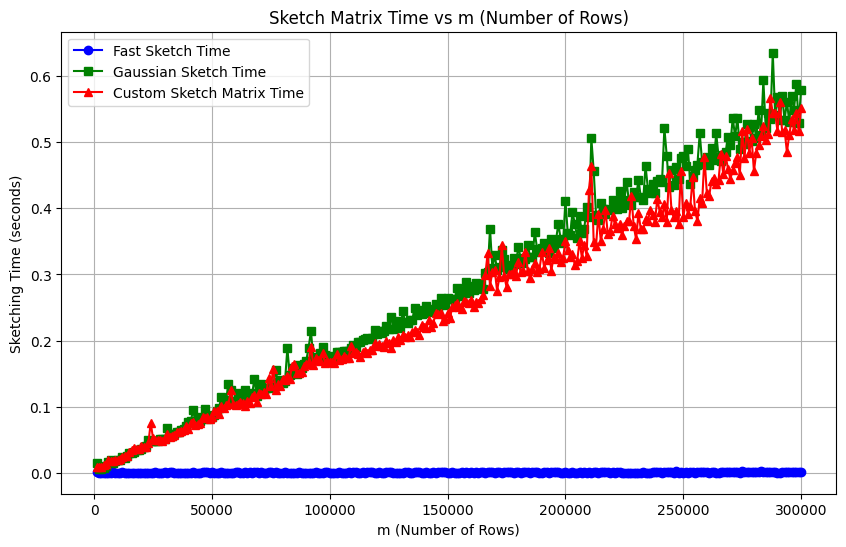

In [30]:
m_values = generation_of_sketch_df['m']
fast_sketch_times = generation_of_sketch_df['Fast Sketch Time']
gaussian_sketch_times = generation_of_sketch_df['Gaussian Sketch Time']
custom_sketch_times = generation_of_sketch_df['Custom Sketch Matrix Time']

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each sketching time
plt.plot(m_values, fast_sketch_times, label='Fast Sketch Time', marker='o', linestyle='-', color='blue')
plt.plot(m_values, gaussian_sketch_times, label='Gaussian Sketch Time', marker='s', linestyle='-', color='green')
plt.plot(m_values, custom_sketch_times, label='Custom Sketch Matrix Time', marker='^', linestyle='-', color='red')

# Adding labels and title
plt.xlabel('m (Number of Rows)')
plt.ylabel('Sketching Time (seconds)')
plt.title('Sketch Matrix Time vs m (Number of Rows)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [12]:
# Set parameters
d = 100  # Number of columns
non_zero_entries = 10
results = []
m = 2000

for n in range(5000, 100001, 5000):
    true_w = np.random.randn(d)
    X = np.random.randn(n, d)

    # Add noise to responses
    y = X @ true_w + np.random.randn(n) * 0.1

    # Time for fast_sketch_matrix
    start_time = time.time()
    fast_sketch_matrix_result = fast_sketch_matrix(m, n)  # sketch for d rows, n columns
    sketching_time_fast = time.time() - start_time

    # Multiply the sketch with the dataset
    start_time = time.time()
    fast_sketch_multiplication = fast_sketch_matrix_result @ X
    multiplication_time_fast = time.time() - start_time


    # Time for gaussian_sketch_matrix
    start_time = time.time()
    gaussian_sketch_matrix_result = gaussian_sketch_matrix(m, n)  # sketch for d rows, n columns
    sketching_time_gaussian = time.time() - start_time

    # Multiply the sketch with the dataset
    start_time = time.time()
    gaussian_sketch_multiplication = gaussian_sketch_matrix_result @ X
    multiplication_time_gaussian = time.time() - start_time


    # Time for sketch_matrix
    start_time = time.time()
    sketch_matrix_result = sketch_matrix(m, n, non_zero_entries)
    sketching_time_custom = time.time() - start_time

    # Multiply the sketch with the dataset
    start_time = time.time()
    custom_sketch_multiplication = sketch_matrix_result @ X
    multiplication_time_custom = time.time() - start_time


    # Store the results in the list
    results.append({
        'n': n,
        'Fast Sketch Time': sketching_time_fast,
        'Fast Sketch Multiplication Time': multiplication_time_fast,
        'Gaussian Sketch Time': sketching_time_gaussian,
        'Gaussian Sketch Multiplication Time': multiplication_time_gaussian,
        'Custom Sketch Time': sketching_time_custom,
        'Custom Sketch Multiplication Time': multiplication_time_custom,
    })

# Convert results into a DataFrame
matrix_multiplication_df = pd.DataFrame(results)

In [29]:
matrix_multiplication_df.head()

,n,Fast Sketch Time,Fast Sketch Multiplication Time,Gaussian Sketch Time,Gaussian Sketch Multiplication Time,Custom Sketch Time,Custom Sketch Multiplication Time
0,5000,0.001328,0.001001,0.217432,0.017242,0.340712,0.014822
1,10000,0.000000,0.001000,0.391654,0.029684,0.710890,0.029539
2,15000,0.000995,0.002275,0.603735,0.047748,1.088376,0.045396
3,20000,0.001322,0.003091,0.793831,0.068827,1.382863,0.088282
4,25000,0.001573,0.006543,1.119159,0.082432,1.913760,0.110529


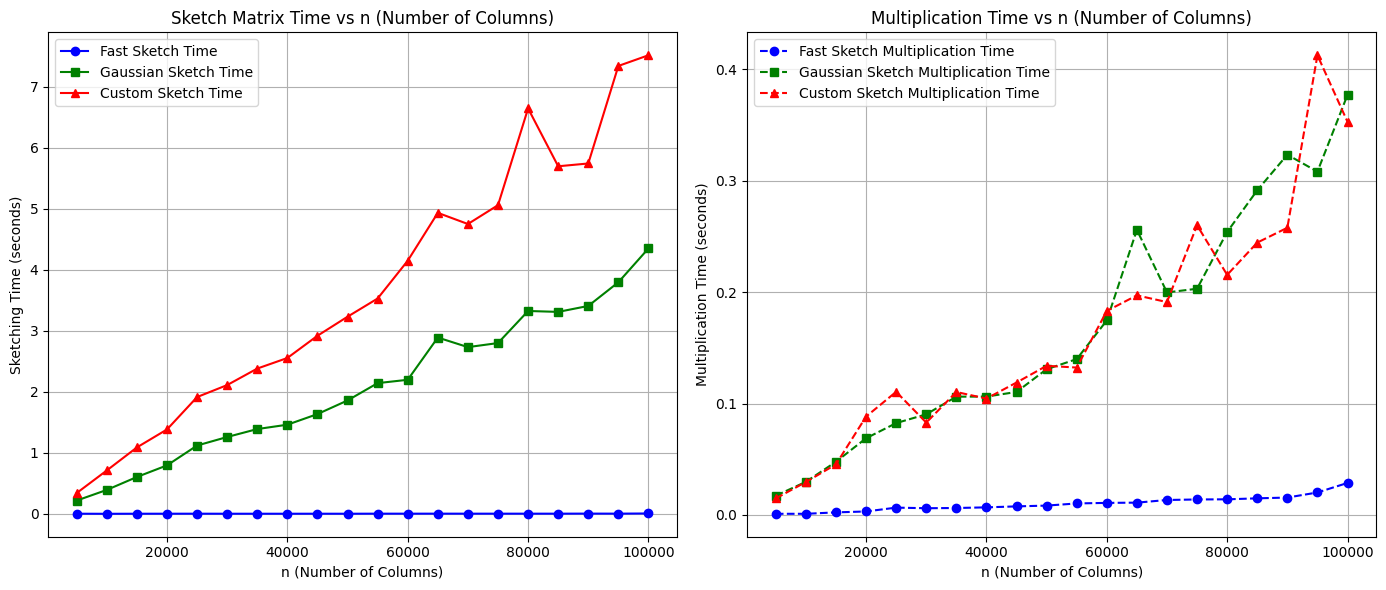

In [31]:
n_values = matrix_multiplication_df['n']
fast_sketch_times = matrix_multiplication_df['Fast Sketch Time']
fast_multiplication_times = matrix_multiplication_df['Fast Sketch Multiplication Time']
gaussian_sketch_times = matrix_multiplication_df['Gaussian Sketch Time']
gaussian_multiplication_times = matrix_multiplication_df['Gaussian Sketch Multiplication Time']
custom_sketch_times = matrix_multiplication_df['Custom Sketch Time']
custom_multiplication_times = matrix_multiplication_df['Custom Sketch Multiplication Time']

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot sketching times in the first subplot
axes[0].plot(n_values, fast_sketch_times, label='Fast Sketch Time', marker='o', linestyle='-', color='blue')
axes[0].plot(n_values, gaussian_sketch_times, label='Gaussian Sketch Time', marker='s', linestyle='-', color='green')
axes[0].plot(n_values, custom_sketch_times, label='Custom Sketch Time', marker='^', linestyle='-', color='red')

axes[0].set_xlabel('n (Number of Columns)')
axes[0].set_ylabel('Sketching Time (seconds)')
axes[0].set_title('Sketch Matrix Time vs n (Number of Columns)')
axes[0].legend()
axes[0].grid(True)

# Plot multiplication times in the second subplot
axes[1].plot(n_values, fast_multiplication_times, label='Fast Sketch Multiplication Time', marker='o', linestyle='--', color='blue')
axes[1].plot(n_values, gaussian_multiplication_times, label='Gaussian Sketch Multiplication Time', marker='s', linestyle='--', color='green')
axes[1].plot(n_values, custom_multiplication_times, label='Custom Sketch Multiplication Time', marker='^', linestyle='--', color='red')

axes[1].set_xlabel('n (Number of Columns)')
axes[1].set_ylabel('Multiplication Time (seconds)')
axes[1].set_title('Multiplication Time vs n (Number of Columns)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

plt.show()